In [ ]:
class GPTConfig:
    def __init__(self):
        self.vocab_size = meta["vocab_size"]  # ~32,000 for BanglaT5
        self.block_size = 128                 # Context length
        self.n_layer = 8                      # Number of transformer blocks
        self.n_head = 8                       # Number of attention heads
        self.n_embd = 512                     # Embedding dimension
        self.dropout = 0.1                    # Regularization

In [ ]:
def calculate_parameters():
    vocab_size = 32100
    n_embd = 512
    n_layer = 8
    n_head = 8

    # Token embeddings
    token_emb_params = vocab_size * n_embd

    # Position embeddings
    pos_emb_params = 128 * n_embd  # block_size * n_embd

    # Each transformer block
    # Attention: 4 linear layers (Q, K, V, proj)
    attn_params = 4 * (n_embd * n_embd)
    # MLP: 2 linear layers (4*n_embd → n_embd)
    mlp_params = n_embd * (4 * n_embd) + (4 * n_embd) * n_embd
    # Layer norms (2 per block)
    ln_params = 2 * n_embd

    block_params = attn_params + mlp_params + ln_params
    total_block_params = n_layer * block_params

    # Final layer norm and head
    final_ln_params = n_embd
    head_params = n_embd * vocab_size

    total = token_emb_params + pos_emb_params + total_block_params + final_ln_params + head_params

    print(f"Token Embeddings: {token_emb_params/1e6:.2f}M")
    print(f"Position Embeddings: {pos_emb_params/1e6:.2f}M")
    print(f"Transformer Blocks: {total_block_params/1e6:.2f}M")
    print(f"Final Head: {head_params/1e6:.2f}M")
    print(f"Total Parameters: {total/1e6:.2f}M")

calculate_parameters()

Token Embeddings: 16.44M
Position Embeddings: 0.07M
Transformer Blocks: 25.17M
Final Head: 16.44M
Total Parameters: 58.11M


In [ ]:
from transformers import AutoTokenizer, T5Model
import torch

# Load tokenizer and encoder-decoder model
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglat5")
model = T5Model.from_pretrained("csebuetnlp/banglat5")

# Input text
text = "আমি বাংলায় কথা বলি"

# Tokenize
inputs = tokenizer(text, return_tensors="pt")

# Pass through encoder to get token embeddings
with torch.no_grad():
    encoder_outputs = model.encoder(**inputs)

# Extract token-level vectors
token_embeddings = encoder_outputs.last_hidden_state.squeeze(0)  # Shape: (seq_len, 512)
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())

# Show first 10 dims of each token's embedding
for i, (token, vector) in enumerate(zip(tokens, token_embeddings)):
    print(f"{i+1}. Token: '{token}' → {vector}")


1. Token: '▁আমি' → tensor([ 3.8904e-02, -5.4560e-03,  1.5565e-01, -2.2271e-01,  2.1094e-01,
         2.4145e-02,  4.8329e-02,  2.9140e-02, -8.5793e-03,  4.7105e-02,
        -7.6535e-02,  6.3955e-03,  1.6493e-02, -5.8595e-02, -2.3978e-01,
         4.2552e-02, -2.0625e-02,  9.3497e-02,  2.4191e-01,  1.5555e-01,
        -1.0927e-01,  9.3477e-02, -1.3202e-02, -1.1819e-01, -6.0679e-02,
        -2.9357e-02,  2.0075e-02, -6.9545e-02, -5.1615e-02, -2.4857e-02,
        -4.6616e-02, -2.7636e-02,  2.4947e-02,  1.1155e-02, -7.5722e-02,
         8.8244e-02, -6.9582e-02,  2.4739e-01,  2.8190e-02, -3.0684e-01,
         1.1139e-01, -1.2097e-01,  7.5894e-02, -9.0453e-02,  1.9508e-01,
        -1.6815e-01, -6.1600e-02,  6.5010e-02,  3.7247e-01, -6.2258e-02,
         1.3307e-01, -2.2310e-01, -1.4692e-02,  1.9458e-01, -3.6996e-02,
         1.4076e-01, -5.4206e-04, -6.9578e-02,  4.2316e-02,  1.8661e-02,
        -4.9393e-02,  5.6061e-02,  4.8090e-02,  5.9825e-02, -4.6135e-02,
        -1.9118e-01,  1.6947e-01

In [ ]:
def analyze_embedding_dimensions():
    """Understand the trade-off between embedding size and model capacity"""

    vocab_size = 32100
    embedding_dims = [128, 256, 512, 1024]

    print("Embedding Dimension Analysis:")
    print("-" * 50)

    for dim in embedding_dims:
        params = vocab_size * dim
        print(f"Embedding dim: {dim}")
        print(f"  Parameters: {params:,} ({params/1e6:.2f}M)")
        print(f"  Memory (float32): {params*4/1024/1024:.2f} MB")
        print(f"  Expressiveness: {'Low' if dim < 256 else 'Medium' if dim < 512 else 'High'}")
        print()

analyze_embedding_dimensions()

Embedding Dimension Analysis:
--------------------------------------------------
Embedding dim: 128
  Parameters: 4,108,800 (4.11M)
  Memory (float32): 15.67 MB
  Expressiveness: Low

Embedding dim: 256
  Parameters: 8,217,600 (8.22M)
  Memory (float32): 31.35 MB
  Expressiveness: Medium

Embedding dim: 512
  Parameters: 16,435,200 (16.44M)
  Memory (float32): 62.70 MB
  Expressiveness: High

Embedding dim: 1024
  Parameters: 32,870,400 (32.87M)
  Memory (float32): 125.39 MB
  Expressiveness: High



In [ ]:
import torch
import torch.nn as nn

# Dummy GPT-like model class with only what's needed
class TinyGPTEmbedDemo(nn.Module):
    def __init__(self, vocab_size=500, block_size=8, n_embd=16):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)

    def forward_embedding_demo(self, idx, tokenizer=None):
        B, T = idx.size()
        pos = torch.arange(0, T, device=idx.device)

        token_emb = self.token_emb(idx)
        pos_emb = self.pos_emb(pos)

        x = token_emb + pos_emb

        print(f"Token embeddings shape     : {token_emb.shape}")
        print(f"Positional embeddings shape: {pos_emb.shape}")
        print(f"Combined embeddings shape  : {x.shape}")

        print("\nToken-wise Embedding Breakdown for first sentence:")
        for t in range(T):
            token_id = idx[0, t].item()
            token_text = tokenizer.decode([token_id]) if tokenizer else f"id {token_id}"
            token_vec = token_emb[0, t][:5].detach().cpu().numpy()
            pos_vec = pos_emb[t][:5].detach().cpu().numpy()
            comb_vec = x[0, t][:5].detach().cpu().numpy()
            print(f"Token: {token_text:10s} | Pos {t} | TokEmb[:5]: {token_vec.round(3)} | PosEmb[:5]: {pos_vec.round(3)} | Sum[:5]: {comb_vec.round(3)}")

        return x

# Instantiate dummy model
demo_model = TinyGPTEmbedDemo()

# Create dummy token index input (batch_size=1, sequence_length=5)
# This simulates tokenized: ["রহিম", "সারাকে", "ভালোবাসে", "।", "<eos>"] <eos> is - end of sentence token
# with made-up token IDs: [101, 202, 303, 0, 1]
idx = torch.tensor([[101, 202, 303, 0, 1]])

# Call the demo function (no tokenizer needed)
demo_model.forward_embedding_demo(idx)


Token embeddings shape     : torch.Size([1, 5, 16])
Positional embeddings shape: torch.Size([5, 16])
Combined embeddings shape  : torch.Size([1, 5, 16])

Token-wise Embedding Breakdown for first sentence:
Token: id 101     | Pos 0 | TokEmb[:5]: [ 0.261 -0.947 -0.061  0.229 -0.232] | PosEmb[:5]: [-1.238 -1.337  0.152 -0.278  0.225] | Sum[:5]: [-0.977 -2.284  0.091 -0.049 -0.007]
Token: id 202     | Pos 1 | TokEmb[:5]: [ 1.446  0.477 -0.523  0.158  0.084] | PosEmb[:5]: [-1.307 -0.742  0.306  1.892  1.573] | Sum[:5]: [ 0.139 -0.265 -0.216  2.05   1.657]
Token: id 303     | Pos 2 | TokEmb[:5]: [ 0.493 -0.367 -0.407  0.773 -1.619] | PosEmb[:5]: [-0.502 -0.891 -0.399  0.387  0.464] | Sum[:5]: [-0.009 -1.258 -0.806  1.16  -1.155]
Token: id 0       | Pos 3 | TokEmb[:5]: [-0.126 -2.268  1.583  0.491  1.04 ] | PosEmb[:5]: [ 0.204 -1.783  0.837 -0.895 -1.391] | Sum[:5]: [ 0.077 -4.051  2.419 -0.404 -0.351]
Token: id 1       | Pos 4 | TokEmb[:5]: [ 1.267 -0.234  0.301 -2.464 -0.069] | PosEmb[:5]: 

tensor([[[-0.9767, -2.2841,  0.0915, -0.0494, -0.0068,  0.7625,  2.4597,
          -0.6108,  1.4289, -2.2406, -2.2759,  0.4544, -1.9511, -0.0480,
          -0.3135, -3.0045],
         [ 0.1387, -0.2648, -0.2164,  2.0504,  1.6567, -0.8299,  1.1838,
          -0.0691, -1.2788, -2.2135, -0.4820, -0.3062,  1.5035, -1.5401,
          -1.0214, -1.3381],
         [-0.0090, -1.2578, -0.8055,  1.1597, -1.1545, -0.7994, -0.6574,
          -1.2865,  0.7352, -0.7159,  1.7051,  1.0261, -1.2717, -1.4344,
          -3.3872, -0.5389],
         [ 0.0770, -4.0510,  2.4193, -0.4042, -0.3512, -0.9160,  1.4652,
           0.0859, -1.1043,  1.8672, -0.2632, -2.1267,  0.7742,  1.5271,
          -0.8423,  1.8176],
         [ 0.3930, -1.2027,  0.6832, -2.7440, -2.3618, -2.2166,  0.2539,
           3.3841,  1.1149,  0.1560,  2.1672, -0.3326, -1.9245, -0.0571,
           1.7174, -2.2777]]], grad_fn=<AddBackward0>)

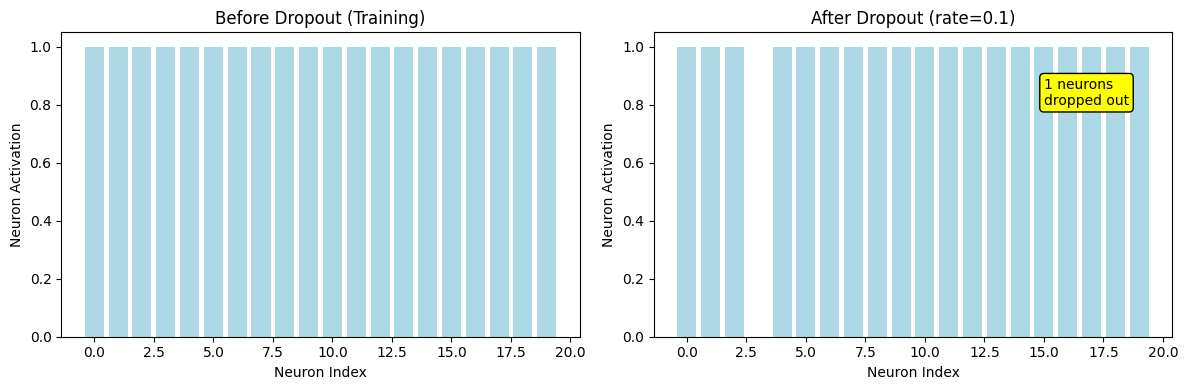

Dropped 1/20 neurons (5.0%)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_dropout():
    """Show how dropout randomly zeros out neurons"""

    # Simulate a layer with 20 neurons
    neurons = np.ones(20)
    dropout_rate = 0.1

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Before dropout
    ax1.bar(range(20), neurons, color='lightblue')
    ax1.set_title('Before Dropout (Training)')
    ax1.set_ylabel('Neuron Activation')
    ax1.set_xlabel('Neuron Index')

    # After dropout
    mask = np.random.random(20) > dropout_rate
    neurons_dropped = neurons * mask
    colors = ['red' if not m else 'lightblue' for m in mask]

    ax2.bar(range(20), neurons_dropped, color=colors)
    ax2.set_title(f'After Dropout (rate={dropout_rate})')
    ax2.set_ylabel('Neuron Activation')
    ax2.set_xlabel('Neuron Index')

    dropped_count = sum(~mask)
    ax2.text(15, 0.8, f'{dropped_count} neurons\ndropped out',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))

    plt.tight_layout()
    plt.show()

    print(f"Dropped {dropped_count}/{len(neurons)} neurons ({100*dropped_count/len(neurons):.1f}%)")

visualize_dropout()

In [ ]:
def analyze_dropout_rates():
    """Understand different dropout rates and their effects"""

    dropout_rates = [0.0, 0.1, 0.2, 0.5]
    effects = [
        "No regularization - High overfitting risk",
        "Light regularization - Good for most tasks",
        "Medium regularization - For complex models",
        "Heavy regularization - May underfit"
    ]

    print("Dropout Rate Analysis:")
    print("-" * 40)

    for rate, effect in zip(dropout_rates, effects):
        print(f"Rate {rate}: {effect}")
        if rate == 0.2:
            print("  → Our choice for the Bangla GPT model ✓")
        print()

analyze_dropout_rates()

Dropout Rate Analysis:
----------------------------------------
Rate 0.0: No regularization - High overfitting risk

Rate 0.1: Light regularization - Good for most tasks

Rate 0.2: Medium regularization - For complex models
  → Our choice for the Bangla GPT model ✓

Rate 0.5: Heavy regularization - May underfit



In [ ]:
import torch
import torch.nn as nn

d_model = 512
d_k = 64

# These are layers, so they are learnable
W_Q = nn.Linear(d_model, d_k)
W_K = nn.Linear(d_model, d_k)
W_V = nn.Linear(d_model, d_k)

# Input X ∈ [batch, seq_len, d_model]
X = torch.rand(32, 20, d_model)  # e.g., batch of 32, 20 tokens

Q = W_Q(X)  # Output shape: [32, 20, 64]
K = W_K(X)
V = W_V(X)

print("Q =" ,Q)
print("K =", K)
print("V =", V)

Q = tensor([[[-0.1806,  0.3008, -0.2343,  ...,  0.1113,  0.0210,  0.5369],
         [-0.1182,  0.1680, -0.2614,  ..., -0.1736,  0.2154,  0.5788],
         [-0.2108,  0.1857,  0.0861,  ..., -0.1360, -0.0550,  0.9361],
         ...,
         [-0.1334,  0.2544, -0.0686,  ...,  0.0380, -0.1911,  0.7548],
         [-0.0717, -0.0115, -0.4418,  ...,  0.0424, -0.0298,  0.6161],
         [-0.1430,  0.6127, -0.3463,  ..., -0.2843, -0.0684,  0.6312]],

        [[-0.0050,  0.4406, -0.5498,  ..., -0.0569,  0.1731,  0.5754],
         [ 0.1778,  0.7387,  0.0163,  ..., -0.0256, -0.1470,  0.4508],
         [-0.1669,  0.4388, -0.4627,  ..., -0.2139,  0.1164,  0.7095],
         ...,
         [-0.2152,  0.5129, -0.3884,  ...,  0.0276,  0.0677,  0.4153],
         [-0.1196,  0.7459, -0.1744,  ..., -0.0205, -0.1331,  0.5624],
         [-0.0992,  0.5029, -0.3945,  ..., -0.0775,  0.0134,  0.7324]],

        [[-0.1110,  0.1212, -0.3109,  ...,  0.2346, -0.0935,  0.6420],
         [-0.0619,  0.4796, -0.2846,  ...

In [ ]:
def calculate_head_dimensions():
    """Understand how embedding dimension is split across heads"""

    n_embd = 512    # Total embedding dimension
    n_head = 8      # Number of attention heads

    head_dim = n_embd // n_head

    print("Multi-Head Dimension Calculation")
    print("=" * 40)
    print(f"Total embedding dimension (n_embd): {n_embd}")
    print(f"Number of heads (n_head): {n_head}")
    print(f"Dimension per head: {n_embd} ÷ {n_head} = {head_dim}")
    print()

    print("Why this matters:")
    print(f"• Each head processes {head_dim}D representations")
    print(f"• All heads combined = {n_head} × {head_dim} = {n_embd}D")
    print("• Different heads can specialize in different patterns")
    print("• Parallel computation across heads")
    print()

    # Verify our model configuration
    assert n_embd % n_head == 0, "n_embd must be divisible by n_head!"
    print("Our configuration is valid!")

calculate_head_dimensions()

Multi-Head Dimension Calculation
Total embedding dimension (n_embd): 512
Number of heads (n_head): 8
Dimension per head: 512 ÷ 8 = 64

Why this matters:
• Each head processes 64D representations
• All heads combined = 8 × 64 = 512D
• Different heads can specialize in different patterns
• Parallel computation across heads

Our configuration is valid!


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
import torch.nn as nn
import math

class CausalSelfAttentionDetailed(nn.Module):
    """Detailed implementation with step-by-step explanations"""

    def __init__(self, cfg):
        super().__init__()

        # Store configuration
        self.n_head = cfg.n_head
        self.n_embd = cfg.n_embd
        self.head_dim = cfg.n_embd // cfg.n_head

        # Linear transformations for Q, K, V
        self.query = nn.Linear(cfg.n_embd, cfg.n_embd, bias=False)
        self.key = nn.Linear(cfg.n_embd, cfg.n_embd, bias=False)
        self.value = nn.Linear(cfg.n_embd, cfg.n_embd, bias=False)

        # Output projection
        self.proj = nn.Linear(cfg.n_embd, cfg.n_embd, bias=False)

        # Dropout layers
        self.attn_drop = nn.Dropout(cfg.dropout)
        self.resid_drop = nn.Dropout(cfg.dropout)

        # Causal mask
        mask = torch.tril(torch.ones(cfg.block_size, cfg.block_size))
        mask = mask.view(1, 1, cfg.block_size, cfg.block_size)
        self.register_buffer("mask", mask)

        print(" CausalSelfAttention initialized!")
        print(f"   Heads: {self.n_head}")
        print(f"   Embedding dim: {self.n_embd}")
        print(f"   Head dim: {self.head_dim}")

    def forward(self, x, verbose=False):
        B, T, C = x.shape  # Batch, Time, Channels

        if verbose:
            print(f"\n Forward pass:")
            print(f"   Input shape: {x.shape}")

        # Step 1: Generate Q, K, V
        q = self.query(x)  # (B, T, C)
        k = self.key(x)    # (B, T, C)
        v = self.value(x)  # (B, T, C)

        if verbose:
            print(f"   Q, K, V shapes: {q.shape}")

        # Step 2: Reshape for multi-head attention
        # (B, T, C) → (B, T, n_head, head_dim) → (B, n_head, T, head_dim)
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        if verbose:
            print(f"   Reshaped Q, K, V: {q.shape}")

        # Step 3: Scaled dot-product attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))

        if verbose:
            print(f"   Attention scores: {att.shape}")

        # Step 4: Apply causal mask
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))

        if verbose:
            print("   Applied causal mask")

        # Step 5: Softmax and dropout
        att = torch.softmax(att, dim=-1)
        att = self.attn_drop(att)

        # Step 6: Apply attention to values
        y = att @ v  # (B, n_head, T, head_dim)

        if verbose:
            print(f"   Attention output: {y.shape}")

        # Step 7: Concatenate heads
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        if verbose:
            print(f"   Concatenated heads: {y.shape}")

        # Step 8: Final projection and dropout
        y = self.resid_drop(self.proj(y))

        if verbose:
            print(f"   Final output: {y.shape}")

        return y

# Test the implementation
def test_causal_attention():
    """Test our attention implementation with sample data"""

    from dataclasses import dataclass

    @dataclass
    class TestConfig:
        n_embd: int = 512
        n_head: int = 8
        block_size: int = 128
        dropout: float = 0.1

    cfg = TestConfig()
    attention = CausalSelfAttentionDetailed(cfg)

    # Sample input: batch_size=2, seq_len=10, embed_dim=512
    x = torch.randn(2, 10, 512)

    print("\n Testing Causal Self-Attention:")
    output = attention(x, verbose=True)

    print(f"\n Test passed! Output shape matches input: {output.shape}")

test_causal_attention()

 CausalSelfAttention initialized!
   Heads: 8
   Embedding dim: 512
   Head dim: 64

 Testing Causal Self-Attention:

 Forward pass:
   Input shape: torch.Size([2, 10, 512])
   Q, K, V shapes: torch.Size([2, 10, 512])
   Reshaped Q, K, V: torch.Size([2, 8, 10, 64])
   Attention scores: torch.Size([2, 8, 10, 10])
   Applied causal mask
   Attention output: torch.Size([2, 8, 10, 64])
   Concatenated heads: torch.Size([2, 10, 512])
   Final output: torch.Size([2, 10, 512])

 Test passed! Output shape matches input: torch.Size([2, 10, 512])
